In [1]:
# import general libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import fsolve
# import from the file multiplayer_prisoners_dilemma.py
from multiplayer_prisoners_dilemma import QLearningAgent
from multiplayer_prisoners_dilemma import Game
from multiplayer_prisoners_dilemma import Simulation

In [2]:
# Figure 1: Stability analysis for the prisoner's dilemma in the deterministic model (2019)
# reward tensor R_i_a0_a1. first index is the agent, second index is the action taken by the agent 1, third index is the action taken by the agent 2
S, P, R, T = 0, 1, 3, 5
R_i_a1_a2 = np.array([[[R, S], 
                       [T, P]],
                       [[R, T], 
                        [S, P]]])

# define the reward function for the two player prisoner's dilemma
def reward_matrix_for_two_player_PD(action_vector, player_id):
    R_i_a1_a2 = np.array([[[R, S], 
                        [T, P]],
                        [[R, T], 
                        [S, P]]])
    return R_i_a1_a2[player_id, action_vector[0], action_vector[1]]

In [3]:
def calculate_fixed_point_policy_for_2x2_matrix_games(R_i_a0_a1, temperature):
    ''' 
    A function that calculates the fixed point policy for a 2x2 matrix game with two agents.
    In reference to the prisoner's dilemma, the notation of the action variables are C and D, but the function is general for any 2x2 matrix game,
    where the first action is indexed by 0 and the second action is indexed by 1.

    Input:
    - R_i_a0_a1: Reward tensor of shape (2, 2, 2) for two agents with two actions each
    - temperature: Temperature parameter that scales the logit function

    Output:
    - results: Fixed point policy for the two agents: [p_1_C, p_2_C]
    '''
    R_i_a0_a1 = R_i_a0_a1
    temperature = temperature
    # rewards for agent 1
    R_1_CC = R_i_a0_a1[0,0,0] # Reward for agent 1 if both agents choose action C
    R_1_CD = R_i_a0_a1[0,0,1] # Reward for agent 1 if agent 1 chooses C and agent 2 chooses D
    R_1_DC = R_i_a0_a1[0,1,0] # Reward for agent 1 if agent 1 chooses D and agent 2 chooses C
    R_1_DD = R_i_a0_a1[0,1,1] # Reward for agent 1 if both agents choose action D
    # rewards for agent 2
    R_2_CC = R_i_a0_a1[1,0,0] # Reward for agent 2 if both agents choose action C
    R_2_CD = R_i_a0_a1[1,0,1] # Reward for agent 2 if agent 1 chooses C and agent 2 chooses D
    R_2_DC = R_i_a0_a1[1,1,0] # Reward for agent 2 if agent 1 chooses D and agent 2 chooses C
    R_2_DD = R_i_a0_a1[1,1,1] # Reward for agent 2 if both agents choose action D

    def f1(p_2_C, temperature):
        return np.exp( (p_2_C*R_1_CC + (1-p_2_C)*R_1_CD)/temperature ) 

    def g1(p_2_C, temperature):
        return np.exp( (p_2_C*R_1_DC + (1-p_2_C)*R_1_DD)/temperature )
    
    def f2(p_1_C, temperature):
        return np.exp( (p_1_C*R_2_CC + (1-p_1_C)*R_2_DC)/temperature )

    def g2(p_1_C, temperature):
        return np.exp( (p_1_C*R_2_CD + (1-p_1_C)*R_2_DD)/temperature )
    
    def fixed_point_equations(variables, temperature = temperature):
        p_1_C, p_2_C = variables
        eq1 = p_1_C - (f1(p_2_C, temperature) / (f1(p_2_C, temperature) + g1(p_2_C, temperature)))
        eq2 = p_2_C - (f2(p_1_C, temperature) / (f2(p_1_C, temperature) + g2(p_1_C, temperature)))
        return [eq1, eq2]
    
    initial_guess = [0.5, 0.5]
    results = fsolve(fixed_point_equations, initial_guess)
    return results

def jacobi_matrix_for_2x2_matrix_games(R_i_a0_a1, p_i_ai, temperature):
    '''
    A function that calculates the Jacobian matrix of a given fixed point in policy space (policy tensor p_i_ai) for a 2x2 matrix game with two agents.
    In reference to the prisoner's dilemma, the notation of the action variables are C and D, but the function is general for any 2x2 matrix game,
    where the first action is indexed by 0 and the second action is indexed by 1.

    Input:
    - R_i_a0_a1: Reward tensor of shape (2, 2, 2) for two agents with two actions each
    - p_i_ai: Policy tensor of shape (2, 2) for two agents with two actions each
    - temperature: Temperature parameter that scales the logit function

    Output:
    - J: Jacobian matrix of the fixed point in policy space
    '''
    # rewards for agent 1
    R_1_CC = R_i_a0_a1[0,0,0] # Reward for agent 1 if both agents choose action C
    R_1_CD = R_i_a0_a1[0,0,1] # Reward for agent 1 if agent 1 chooses C and agent 2 chooses D
    R_1_DC = R_i_a0_a1[0,1,0] # Reward for agent 1 if agent 1 chooses D and agent 2 chooses C
    R_1_DD = R_i_a0_a1[0,1,1] # Reward for agent 1 if both agents choose action D
    # rewards for agent 2
    R_2_CC = R_i_a0_a1[1,0,0] # Reward for agent 2 if both agents choose action C
    R_2_CD = R_i_a0_a1[1,0,1] # Reward for agent 2 if agent 1 chooses C and agent 2 chooses D
    R_2_DC = R_i_a0_a1[1,1,0] # Reward for agent 2 if agent 1 chooses D and agent 2 chooses C
    R_2_DD = R_i_a0_a1[1,1,1] # Reward for agent 2 if both agents choose action D
    # probabilities for agent 1
    p_1_C = p_i_ai[0,0] # Probability for agent 1 to choose action C
    p_2_C = p_i_ai[1,0] # Probability for agent 2 to choose action C

    def f1(p_2_C, temperature):
        return np.exp( (p_2_C*R_1_CC + (1-p_2_C)*R_1_CD)/temperature ) 

    def g1(p_2_C, temperature):
        return np.exp( (p_2_C*R_1_DC + (1-p_2_C)*R_1_DD)/temperature )

    def f2(p_1_C, temperature):
        return np.exp( (p_1_C*R_2_CC + (1-p_1_C)*R_2_DC)/temperature )

    def g2(p_1_C, temperature):
        return np.exp( (p_1_C*R_2_CD + (1-p_1_C)*R_2_DD)/temperature )

    partial_p_1_p_2_C = (R_1_CC - R_1_CD - R_1_DC + R_1_DD) * 1/temperature * f1(p_2_C, temperature) * g1(p_2_C, temperature) / (f1(p_2_C, temperature) + g1(p_2_C, temperature))**2 
    partial_p_2_C_p_1 = (R_2_CC - R_2_DC - R_2_CD + R_2_DD) * 1/temperature * f2(p_1_C, temperature) * g2(p_1_C, temperature) / (f2(p_1_C, temperature) + g2(p_1_C, temperature))**2
    return np.array([[0, partial_p_1_p_2_C],
                    [partial_p_2_C_p_1, 0]])

def stability_analysis(R_i_a0_a1, temperature_array):
    '''
    A function that conducts a stability analysis for the prisoner's dilemma for a range of temperatures.
    The stability analysis includes the calculation of the fixed point policy and the eigenvalues and eigenvectors of the Jacobian matrix at the fixed point.

    Input:
    - R_i_a0_a1: Reward tensor of shape (2, 2, 2) for two agents with two actions each
    - temperature_array: Array of temperatures for which the stability analysis is conducted

    Output:
    - p_fixed_point_array: Array of fixed point policies for the two agents
    - eigenvalues_array: Array of eigenvalues of the Jacobian matrix at the fixed point
    - eigenvectors_array: Array of eigenvectors of the Jacobian matrix at the fixed point
    '''
    p_fixed_point_array = np.zeros((len(temperature_array), 2))
    eigenvalues_array = np.zeros((len(temperature_array), 2))
    eigenvectors_array = np.zeros((len(temperature_array), 2, 2))
    for i in range(len(temperature_array)):
        temperature = temperature_array[i]
        # Calculate the fixed point policy for the prisoner's dilemma for given temperature
        p_fixed_point = calculate_fixed_point_policy_for_2x2_matrix_games(R_i_a0_a1, temperature)
        # update the probability tensor p_i_ai with the fixed point policy
        p_i_ai = np.array([[p_fixed_point[0], 1 - p_fixed_point[0]],
                        [p_fixed_point[1], 1 - p_fixed_point[1]]])
        # Calculate the Jacobian matrix for the prisoner's dilemma at the fixed point
        J = jacobi_matrix_for_2x2_matrix_games(R_i_a0_a1, p_i_ai, temperature)
        eigenvalues, eigenvectors = np.linalg.eig(J)

        # store in arrays
        p_fixed_point_array[i] = p_fixed_point
        eigenvalues_array[i] = eigenvalues
        eigenvectors_array[i] = eigenvectors
    return p_fixed_point_array, eigenvalues_array, eigenvectors_array

# the following functions are only valid for the Prisoner's DIlemma with S, P, R, T = 0, 1, 3, 5 !!! 
# ToDo: generalize the functions for any symmetric 2x2 matrix game

def calculate_fixed_point_policy(temperature, discount_factor, initial_guess = [0, 1], print_solution = True):
    # define four-dimensional system of equations
    def equations(variables, T = temperature, discount_factor = discount_factor):
        a, b, c, d = variables

        eq1 = a - 1 / (np.exp(c/T) + np.exp(d/T)) * (3 * np.exp(c/T)) +\
            discount_factor * max(a,b)
        eq2 = b - 1 / (np.exp(c/T) + np.exp(d/T)) * (5 * np.exp(c/T) + np.exp(d/T)) +\
            discount_factor * max(a,b)
        eq3 = c - 1 / (np.exp(a/T) + np.exp(b/T)) * (3 * np.exp(a/T)) +\
            discount_factor * max(c,d)
        eq4 = d - 1 / (np.exp(a/T) + np.exp(b/T)) * (5 * np.exp(a/T) + np.exp(b/T)) +\
            discount_factor * max(c,d)

        return [eq1, eq2, eq3, eq4]

    # Initial guess for the solution
    a_init, b_init = initial_guess
    initial_guess = [a_init, b_init, a_init, b_init]

    # Solve the system numerically and get information
    result, infodict, ier, msg = fsolve(equations, initial_guess, full_output=True)
    a, b, c, d = result
    fixed_point_policy = np.exp(a/temperature) / (np.exp(a/temperature) + np.exp(b/temperature))

    # prints
    if print_solution:
        print("------------------------------------")
        print(f"Numerical Solution: Q^1_C = {a}, Q^1_D = {b}, Q^2_C = {c}, Q^2_D = {d}")
        print("Q^1_D - Q^1_C =", b - a)
        print(f"Fixed point policy at T={temperature} : ", fixed_point_policy)
        print("------------------------------------")
        print()

    return fixed_point_policy

def calculate_target_Q_values(prob_to_coop_j, discount_factor, print_solution = False):
    # expected rewards for agent i
    Exp_Reward_C = 3 * prob_to_coop_j + 0 * (1. - prob_to_coop_j)
    Exp_Reward_D = 5 * prob_to_coop_j + 1 * (1. - prob_to_coop_j)

    # geometric series for agent i
    Q_max_C = Exp_Reward_C / (1 - discount_factor)
    Q_max_D = Exp_Reward_D / (1 - discount_factor)

    # target Q-values for agent j
    Q_target_C = Exp_Reward_C + discount_factor * max(Q_max_C, Q_max_D)
    Q_target_D = Exp_Reward_D + discount_factor * max(Q_max_C, Q_max_D)

    if print_solution:
        print("------------------------------------")
        print(f"For prob_to_coop_j = {prob_to_coop_j} and discount_factor = {discount_factor}, the target Q-values are:")
        print(f"Q_target_C = {Q_target_C}")
        print(f"Q_target_D = {Q_target_D}")
        print("------------------------------------")
        print()

    return np.array([Q_target_C, Q_target_D])

def calculate_eigenvalues_and_eigenvectors(discount_factor, temperature, learning_rate, print_solution = False):  
    # calculate the fixed point policy and the target Q-values
    fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
    Q_target_C, Q_target_D = calculate_target_Q_values(fixed_point_policy, discount_factor, print_solution = False)

    def p(a, b):
        return np.exp(a/temperature) / (np.exp(a/temperature) + np.exp(b/temperature))

    def partial_p(a, b):
        return np.exp((a+b)/temperature) / ( temperature * (np.exp(a/temperature) + np.exp(b/temperature))**2 )

    def f(a, b, c, d):
        return learning_rate * partial_p(a, b) * ( 3 * p(c, d) + discount_factor * b - a)

    def g(a, b, c, d):
        return 3 * learning_rate * p(a,b) * partial_p(c, d)

    def h(a, b, c, d):
        return learning_rate * partial_p(a, b) * ( 4 * p(c, d) + 1 + (discount_factor - 1) * b)

    def i(a, b, c, d):
        return 4 * learning_rate * (1 - p(a,b)) * partial_p(c, d)

    a, b, c, d = Q_target_C, Q_target_D, Q_target_C, Q_target_D

    # define the Jacobi matrix entries
    if True:
        j_11 = + f(a,b,c,d) - learning_rate * p(a, b) + 1
        j_12 = - f(a,b,c,d) + learning_rate * discount_factor * p(a, b)
        j_13 = + g(a,b,c,d)
        j_14 = - g(a,b,c,d)

        j_21 = - h(a,b,c,d)
        j_22 = + h(a,b,c,d) + learning_rate * (discount_factor - 1) * (1 - p(a, b)) + 1
        j_23 = + i(a,b,c,d)
        j_24 = - i(a,b,c,d)

        j_31 = + g(c,d,a,b)
        j_32 = - g(c,d,a,b)
        j_33 = + f(c,d,a,b) - learning_rate * p(c, d) + 1
        j_34 = - f(c,d,a,b) + learning_rate * discount_factor * p(c, d)

        j_41 = + i(c,d,a,b)
        j_42 = - i(c,d,a,b)
        j_43 = - h(c,d,a,b)
        j_44 = + h(c,d,a,b) + learning_rate * (discount_factor - 1) * (1 - p(c, d)) + 1

    # Define the 4x4 Jacobi matrix 
    J = np.array([[j_11, j_12, j_13, j_14],
                [j_21, j_22, j_23, j_24],
                [j_31, j_32, j_33, j_34],
                [j_41, j_42, j_43, j_44]])

    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(J)
    eigenvalues_betrag = np.abs(eigenvalues)

    # Print the results
    if print_solution:
        print(f"gamma = {discount_factor}")
        print()
        for i in range(len(eigenvalues)):
            print(f"Eigenvalue {i+1}:", eigenvalues[i])
        print()
        for i in range(len(eigenvalues_betrag)):
            print(f"Absolute Eigenvalue {i+1}:", eigenvalues_betrag[i])
        print()
    
    return eigenvalues, eigenvectors

height_ratios = [1, 4]
linestyle_array = [':', '-', '--', '-.']
dpi = 300

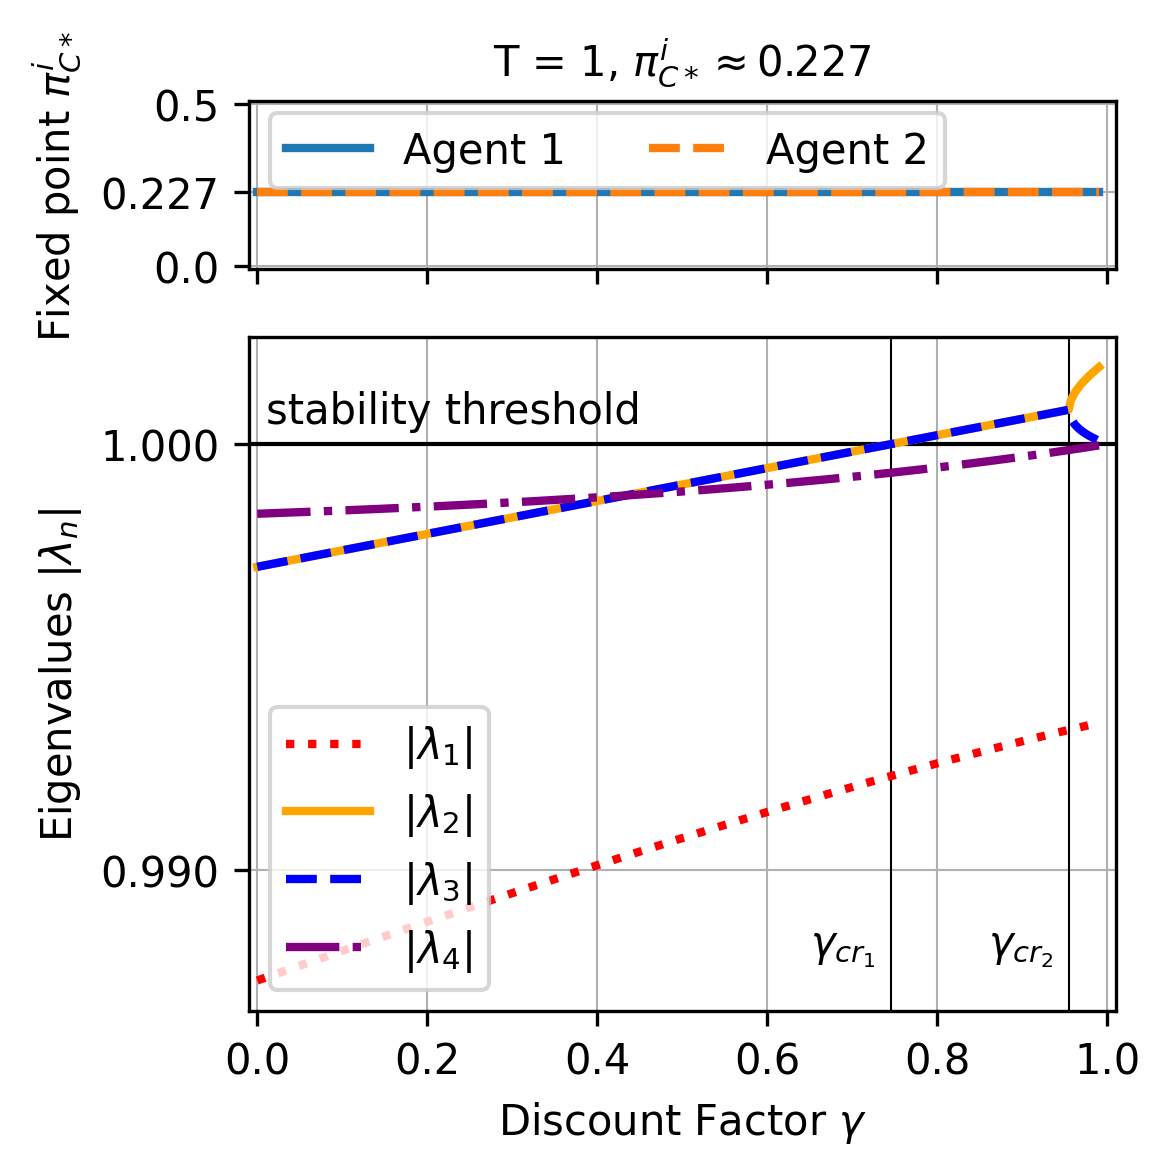

In [4]:
# set the temperature 
temperature = 1
learning_rate = 0.01

# calculate the eigenvalues and eigenvectors for a range of discount factors
discount_factor_array = np.linspace(0., 0.99, 1000)
# calculate the fixed point policy and target Q-values for different discount factors
fixed_point_policy_array = []
# store eigenvalues, their absolute values and eigenvectors for each discount factor
eigenvalues_array = []
eigenvalues_betrag_array = []
eigenvectors_array = []
# calculate the eigenvalues and eigenvectors for each discount factor
for discount_factor in discount_factor_array:
    fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
    eigenvalues, eigenvectors = calculate_eigenvalues_and_eigenvectors(discount_factor, temperature, learning_rate, print_solution = False)
    eigenvalues_betrag = np.abs(eigenvalues)

    # Store the results
    fixed_point_policy_array.append(fixed_point_policy)
    eigenvalues_array.append(eigenvalues)
    eigenvalues_betrag_array.append(eigenvalues_betrag)
    eigenvectors_array.append(eigenvectors)

    # check if all eigenvectors are real valued
    if False:
        if np.all(np.isreal(eigenvectors)):
            print("Eigenvectors are real valued for discount factor =", discount_factor)

def plot_eigenvalues_vs_discount_factor(eigenvalues_betrag_array, discount_factor_array, temperature, learning_rate):
    # cosmetics
    fontsize = None
    fig, ax = plt.subplots(2, 1, figsize=(4, 4), dpi=dpi, sharex=True, gridspec_kw={'height_ratios': height_ratios})

    # Plot the fixed point policy
    ax[0].plot(discount_factor_array, fixed_point_policy_array, label="Agent 1", linewidth=2)#label='$\pi^1_{C*} \\approx $'+f'{fixed_point_policy:.3f}')
    ax[0].plot(discount_factor_array, fixed_point_policy_array, label="Agent 2", linewidth=2, linestyle="--")#label='$\pi^2_{C*} \\approx $'+f'{fixed_point_policy:.3f}')
    ax[0].set_ylabel('Fixed point $\pi^i_{C*}$')# for T = '+f'{temperature}')
    ax[0].set_ylim(-0.01, 0.51)
    # # Set custom y-ticks and labels
    ax[0].set_yticks([0.0, 0.227, 0.5])
    ax[0].set_yticklabels(['0.0', '0.227', '0.5'])
    # customize the position of the legend
    ax[0].legend(ncol=2, bbox_to_anchor=(0., 1.05), loc='upper left')
    ax[0].grid(linewidth=0.5)

    color_array = ['red', 'orange', 'blue', 'purple']
    # plot horizontal line at y = 1 for the whole x-axis
    ax[1].axhline(y=1, color='black', linestyle='-', linewidth=1)
    # Plot the absolute values of the eigenvalues
    for i in range(len(eigenvalues_betrag_array[0])):
        ax[1].plot(discount_factor_array, [eigenvalues_betrag[i] for eigenvalues_betrag in eigenvalues_betrag_array], label=f"|$\lambda_{i+1}$|", linestyle=linestyle_array[i], color=color_array[i], linewidth=2, zorder=5)
    # plot a dummy line to get the legend right
    #ax[1].axvline(x=0, label=' ', color='white', alpha=0.)
    # Plot vertical line at x = 0.745676 and x = 0.954936228028
    ax[1].axvline(x=0.745676, color='black', linestyle='-', linewidth = 0.5, alpha= 1)#, label=r'$\gamma_{cr_1} \approx$ 0.74')
    ax[1].axvline(x=0.954936228028, color='black', linestyle='-', linewidth = 0.5, alpha= 1)#, label=r'$\gamma_{cr_2} \approx$ 0.95') 
    # plot the labels of the axvlines directly on the line instead of the legend
    ax[1].text(0.65, 0.988, r'$\gamma_{cr_1}$', rotation=0) # coordinates are (x, y) in data coordinates
    ax[1].text(0.86, 0.988, r'$\gamma_{cr_2}$', rotation=0) # coordinates are (x, y) in data coordinates
    ax[1].text(0.01, 1.0005, 'stability threshold', rotation=0) # coordinates are (x, y) in data coordinates
    # why does the text not show up?
    ax[1].set_xlabel(f"Discount Factor $\gamma$", fontsize=fontsize)
    ax[1].set_ylabel("Eigenvalues $|\lambda_n|$", fontsize=fontsize)
    ax[1].grid(linewidth=0.5)
    # Plot legend in box outside of plot
    ax[1].legend(loc='lower left', fontsize=fontsize, ncol=1)#, bbox_to_anchor=(0.5, -0.5))
    # Set ticks of label to fontsize
    ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
    # Plot only 3 y ticks, otherwise it is too crowded
    ax[1].locator_params(axis='y', nbins=3)
    # limit the ticks on the y-axis to :.3f format for the eigenvalues
    ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    x_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.]
    x_tick_labels = ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']
    ax[1].set_xticks(x_ticks)
    ax[1].set_xticklabels(x_tick_labels)
    ax[1].set_xlim(-0.01, 1.01)

    #plot title with the temperature
    #ax[1].title(f'T = {temperature}', fontsize=fontsize)
    # title
    ax[0].set_title(f'T = {temperature}, '+r'$\pi^i_{C*} \approx $'+f'{fixed_point_policy:.3f}', fontsize=fontsize)
    #fig.text(0.55, 0.935, f'QL model. Initial joint policy: {initial_probability_pair}', fontsize=fontsize, ha='center')

    plt.tight_layout()
    plt.savefig(f'Figures/PaperFigures/Fig4_PD_DetModel_new_StabilityAnalysis_T_{temperature}.pdf', dpi=dpi)
    plt.show()

# show the bifurcation by plotting the absolute values of the eigenvalues
plot_eigenvalues_vs_discount_factor(eigenvalues_betrag_array, discount_factor_array, temperature, learning_rate)

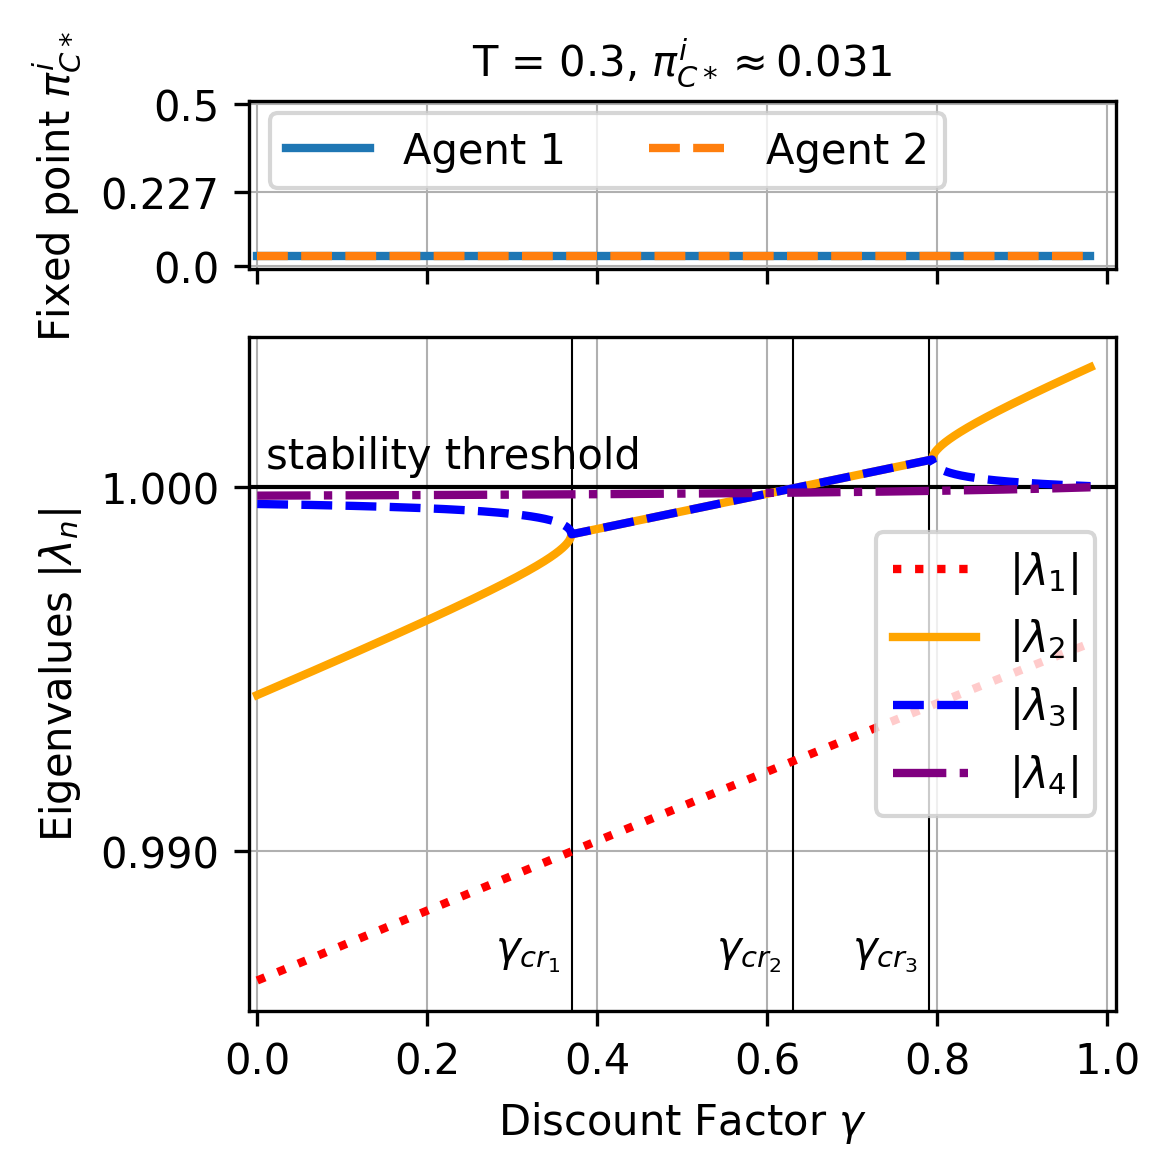

In [5]:
# set the temperature 
temperature = 0.3

# calculate the eigenvalues and eigenvectors for a range of discount factors
discount_factor_array = np.linspace(0., 0.98, 1000)
# calculate the fixed point policy and target Q-values for different discount factors
fixed_point_policy_array = []
# store eigenvalues, their absolute values and eigenvectors for each discount factor
eigenvalues_array = []
eigenvalues_betrag_array = []
eigenvectors_array = []
# calculate the eigenvalues and eigenvectors for each discount factor
for discount_factor in discount_factor_array:
    fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
    eigenvalues, eigenvectors = calculate_eigenvalues_and_eigenvectors(discount_factor, temperature, learning_rate, print_solution = False)
    eigenvalues_betrag = np.abs(eigenvalues)

    # Store the results
    fixed_point_policy_array.append(fixed_point_policy)
    eigenvalues_array.append(eigenvalues)
    eigenvalues_betrag_array.append(eigenvalues_betrag)
    eigenvectors_array.append(eigenvectors)

    # check if all eigenvectors are real valued
    if False:
        if np.all(np.isreal(eigenvectors)):
            print("Eigenvectors are real valued for discount factor =", discount_factor)

def plot_eigenvalues_vs_discount_factor(eigenvalues_betrag_array, discount_factor_array, temperature, learning_rate):
    # cosmetics
    fontsize = None
    fig, ax = plt.subplots(2, 1, figsize=(4, 4), dpi=dpi, sharex=True, gridspec_kw={'height_ratios': height_ratios})

    # Plot the fixed point policy
    ax[0].plot(discount_factor_array, fixed_point_policy_array, label="Agent 1", linewidth=2)#label='$\pi^1_{C*} \\approx $'+f'{fixed_point_policy:.3f}')
    ax[0].plot(discount_factor_array, fixed_point_policy_array, label="Agent 2", linewidth=2, linestyle="--")#label='$\pi^2_{C*} \\approx $'+f'{fixed_point_policy:.3f}')
    ax[0].set_ylabel('Fixed point $\pi^i_{C*}$')# for T = '+f'{temperature}')
    ax[0].set_ylim(-0.01, 0.51)
    # # Set custom y-ticks and labels
    ax[0].set_yticks([0.0, 0.227, 0.5])
    ax[0].set_yticklabels(['0.0', '0.227', '0.5'])
    # customize the position of the legend
    ax[0].legend(ncol=2, bbox_to_anchor=(0., 1.05), loc='upper left')
    ax[0].grid(linewidth=0.5)

    color_array = ['red', 'orange', 'blue', 'purple']
    # plot horizontal line at y = 1 for the whole x-axis
    ax[1].axhline(y=1, color='black', linestyle='-', linewidth=1)
    # Plot the absolute values of the eigenvalues
    for i in range(len(eigenvalues_betrag_array[0])):
        ax[1].plot(discount_factor_array, [eigenvalues_betrag[i] for eigenvalues_betrag in eigenvalues_betrag_array], label=f"|$\lambda_{i+1}$|", linestyle=linestyle_array[i], color=color_array[i], linewidth=2, zorder=5)
    # plot a dummy line to get the legend right
    #ax[1].axvline(x=0, label=' ', color='white', alpha=0.)
    # Plot vertical line at x = 0.745676 and x = 0.954936228028
    ax[1].axvline(x=0.37, color='black', linestyle='-', linewidth=.5)#, label=r'$\gamma_{cr_1} \approx$ 0.74') #x=0.745676
    ax[1].axvline(x=0.63, color='black', linestyle='-', linewidth=.5)#, label=r'$\gamma_{cr_2} \approx$ 0.95') #x=0.954936228028
    ax[1].axvline(x=0.79, color='black', linestyle='-', linewidth=.5)#, label=r'$\gamma_{cr_2} \approx$ 0.95') #x=0.954936228028
    # plot the labels of the axvlines directly on the line instead of the legend
    ax[1].text(0.28, 0.987, r'$\gamma_{cr_1}$', rotation=0) # coordinates are (x, y) in data coordinates
    ax[1].text(0.54, 0.987, r'$\gamma_{cr_2}$', rotation=0) # coordinates are (x, y) in data coordinates
    ax[1].text(0.7, 0.987, r'$\gamma_{cr_3}$', rotation=0) # coordinates are (x, y) in data coordinates
    # stability threshold
    ax[1].text(0.01, 1.0005, 'stability threshold', rotation=0) # coordinates are (x, y) in data coordinates
    # why does the text not show up?
    ax[1].set_xlabel(f"Discount Factor $\gamma$", fontsize=fontsize)
    ax[1].set_ylabel("Eigenvalues $|\lambda_n|$", fontsize=fontsize)
    ax[1].grid(linewidth=0.5)
    # Plot legend in box outside of plot
    ax[1].legend(loc='center right', fontsize=fontsize, ncol=1)#, bbox_to_anchor=(0.5, -0.5))
    # Set ticks of label to fontsize
    ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
    # Plot only 3 y ticks, otherwise it is too crowded
    ax[1].locator_params(axis='y', nbins=3)
    # limit the ticks on the y-axis to :.3f format for the eigenvalues
    ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    x_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.]
    x_tick_labels = ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']
    ax[1].set_xticks(x_ticks)
    ax[1].set_xticklabels(x_tick_labels)
    ax[1].set_xlim(-0.01, 1.01)

    #plot title with the temperature
    # title
    ax[0].set_title(f'T = {temperature}, '+r'$\pi^i_{C*} \approx $'+f'{fixed_point_policy:.3f}', fontsize=fontsize)

    plt.tight_layout()
    plt.savefig(f'Figures/PaperFigures/Fig4_PD_DetModel_new_StabilityAnalysis_T_{temperature}.pdf', dpi=dpi)
    plt.show()

# show the bifurcation by plotting the absolute values of the eigenvalues
plot_eigenvalues_vs_discount_factor(eigenvalues_betrag_array, discount_factor_array, temperature, learning_rate)

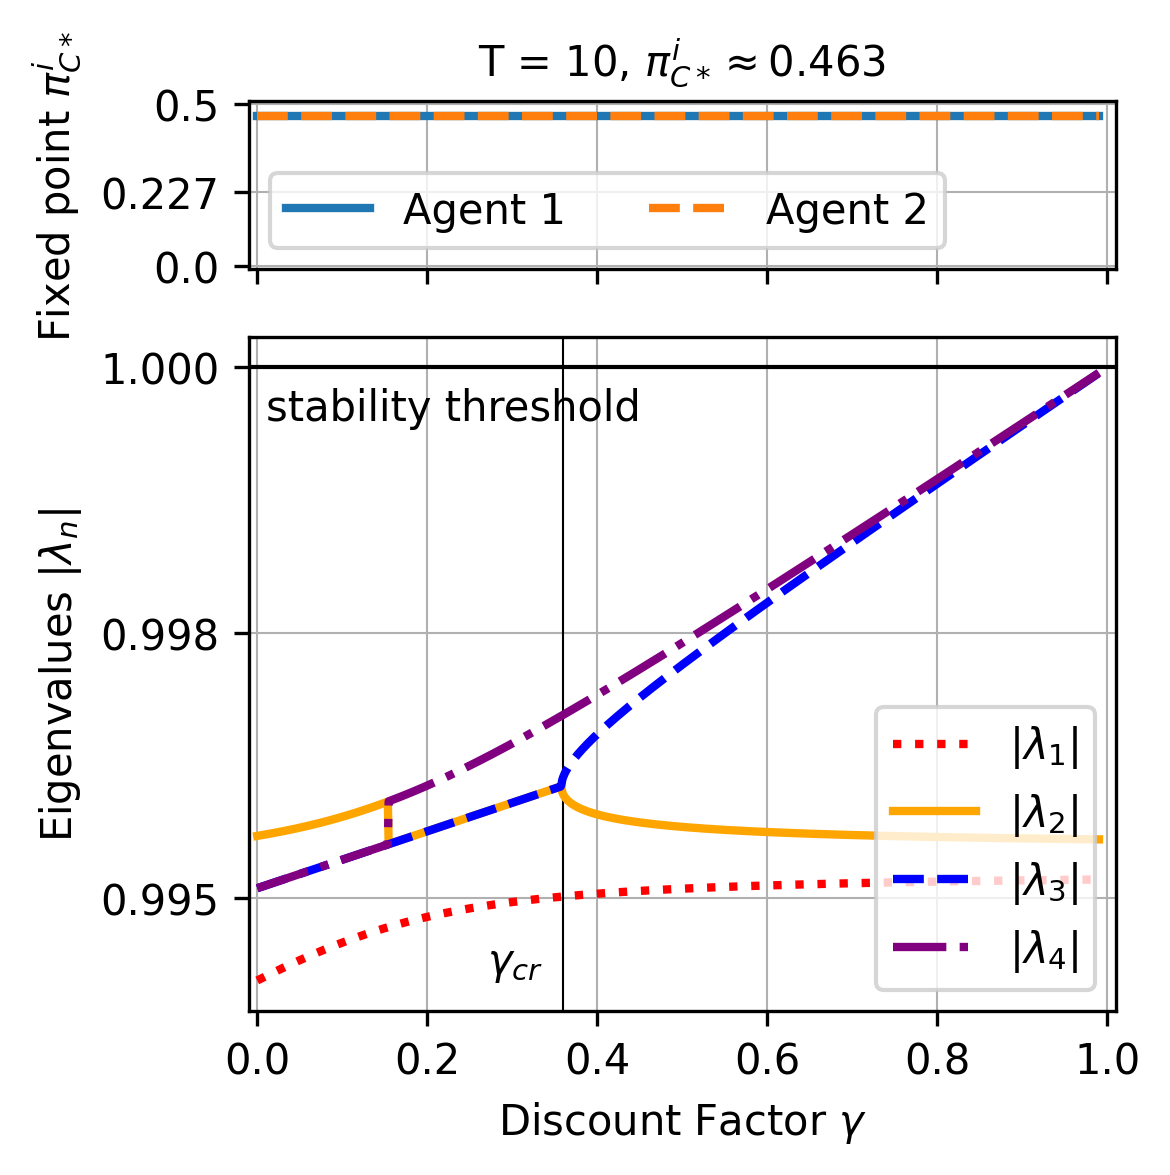

In [6]:
# set the temperature 
temperature = 10

# calculate the eigenvalues and eigenvectors for a range of discount factors
discount_factor_array = np.linspace(0., 0.99, 1000)
# calculate the fixed point policy and target Q-values for different discount factors
fixed_point_policy_array = []
# store eigenvalues, their absolute values and eigenvectors for each discount factor
eigenvalues_array = []
eigenvalues_betrag_array = []
eigenvectors_array = []
# calculate the eigenvalues and eigenvectors for each discount factor
for discount_factor in discount_factor_array:
    fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
    eigenvalues, eigenvectors = calculate_eigenvalues_and_eigenvectors(discount_factor, temperature, learning_rate, print_solution = False)
    eigenvalues_betrag = np.abs(eigenvalues)

    # Store the results
    fixed_point_policy_array.append(fixed_point_policy)
    eigenvalues_array.append(eigenvalues)
    eigenvalues_betrag_array.append(eigenvalues_betrag)
    eigenvectors_array.append(eigenvectors)

    # check if all eigenvectors are real valued
    if False:
        if np.all(np.isreal(eigenvectors)):
            print("Eigenvectors are real valued for discount factor =", discount_factor)

def plot_eigenvalues_vs_discount_factor(eigenvalues_betrag_array, discount_factor_array, temperature, learning_rate):
    # cosmetics
    fontsize = None
    fig, ax = plt.subplots(2, 1, figsize=(4, 4), dpi=dpi, sharex=True, gridspec_kw={'height_ratios': height_ratios})

    # Plot the fixed point policy
    ax[0].plot(discount_factor_array, fixed_point_policy_array, label="Agent 1", linewidth=2)#label='$\pi^1_{C*} \\approx $'+f'{fixed_point_policy:.3f}')
    ax[0].plot(discount_factor_array, fixed_point_policy_array, label="Agent 2", linewidth=2, linestyle="--")#label='$\pi^2_{C*} \\approx $'+f'{fixed_point_policy:.3f}')
    ax[0].set_ylabel('Fixed point $\pi^i_{C*}$')# for T = '+f'{temperature}')
    ax[0].set_ylim(-0.01, 0.51)
    # # Set custom y-ticks and labels
    ax[0].set_yticks([0.0, 0.227, 0.5])
    ax[0].set_yticklabels(['0.0', '0.227', '0.5'])
    # customize the position of the legend
    ax[0].legend(ncol=2, loc='lower left')
    ax[0].grid(linewidth=0.5)

    color_array = ['red', 'orange', 'blue', 'purple']
    # plot horizontal line at y = 1 for the whole x-axis
    ax[1].axhline(y=1, color='black', linestyle='-', linewidth=1)
    # Plot the absolute values of the eigenvalues
    for i in range(len(eigenvalues_betrag_array[0])):
        ax[1].plot(discount_factor_array, [eigenvalues_betrag[i] for eigenvalues_betrag in eigenvalues_betrag_array], label=f"|$\lambda_{i+1}$|", linestyle=linestyle_array[i], color=color_array[i], linewidth=2, zorder=5)
    # plot a dummy line to get the legend right
    #ax[1].axvline(x=0, label=' ', color='white', alpha=0.)
    # Plot vertical line at x = 0.745676 and x = 0.954936228028
    ax[1].axvline(x=0.36, color='black', linestyle='-', linewidth=.5)#, label=r'$\gamma_{cr_1} \approx$ 0.74') #x=0.745676
    # plot the labels directly on the line instead of the legend
    ax[1].text(0.27, 0.9943, r'$\gamma_{cr}$', rotation=0) # coordinates are (x, y) in data coordinates
    # plot text stability threshold
    ax[1].text(0.01, 0.9995, 'stability threshold', rotation=0) # coordinates are (x, y) in data coordinates
    # why does the text not show up?
    ax[1].set_xlabel(f"Discount Factor $\gamma$", fontsize=fontsize)
    ax[1].set_ylabel("Eigenvalues $|\lambda_n|$", fontsize=fontsize)
    ax[1].grid(linewidth=0.5)
    # Plot legend in box outside of plot
    ax[1].legend(loc='lower right', fontsize=fontsize, ncol=1)#, bbox_to_anchor=(0.5, -0.5))
    # Set ticks of label to fontsize
    ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
    # limit the ticks on the y-axis to :.3f format for the eigenvalues
    ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    # Plot only 3 y ticks, otherwise it is too crowded
    ax[1].locator_params(axis='y', nbins=3)

    x_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.]
    x_tick_labels = ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']
    ax[1].set_xticks(x_ticks)
    ax[1].set_xticklabels(x_tick_labels)
    ax[1].set_xlim(-0.01, 1.01)

    #plot title with the temperature
    # title
    ax[0].set_title(f'T = {temperature}, '+r'$\pi^i_{C*} \approx $'+f'{fixed_point_policy:.3f}', fontsize=fontsize)

    plt.tight_layout()
    plt.savefig(f'Figures/Pape4_PD_DetModel_new_StabilityAnalysis_T_{temperature}.pdf', dpi=dpi)
    plt.show()

# show the bifurcation by plotting the absolute values of the eigenvalues
plot_eigenvalues_vs_discount_factor(eigenvalues_betrag_array, discount_factor_array, temperature, learning_rate)